In [1]:
from qiskit_algorithms.state_fidelities import ComputeUncompute
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA,SPSA,ADAM
from qiskit.primitives import Sampler
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap

from IPython.display import clear_output
import time
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

algorithm_globals.random_seed = 123
DATA_PATH = '../data/processed/winedata.csv'
MODEL_PATH='../model/'
max_iter=100

data = pd.read_csv(DATA_PATH)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(data.drop('target',axis=1),data.target,test_size=0.25,random_state=algorithm_globals.random_seed)
print(type(X_Train))
print(type(Y_Train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


C:\Users\Zeff\AppData\Local\Temp\ipykernel_14920\2641333385.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA,SPSA,ADAM


In [2]:
scarlar = StandardScaler();
X_Train = scarlar.fit_transform(X_Train);
X_Test = scarlar.fit_transform(X_Test);
y_train = np.array(Y_Train)
y_test = np.array(Y_Test)

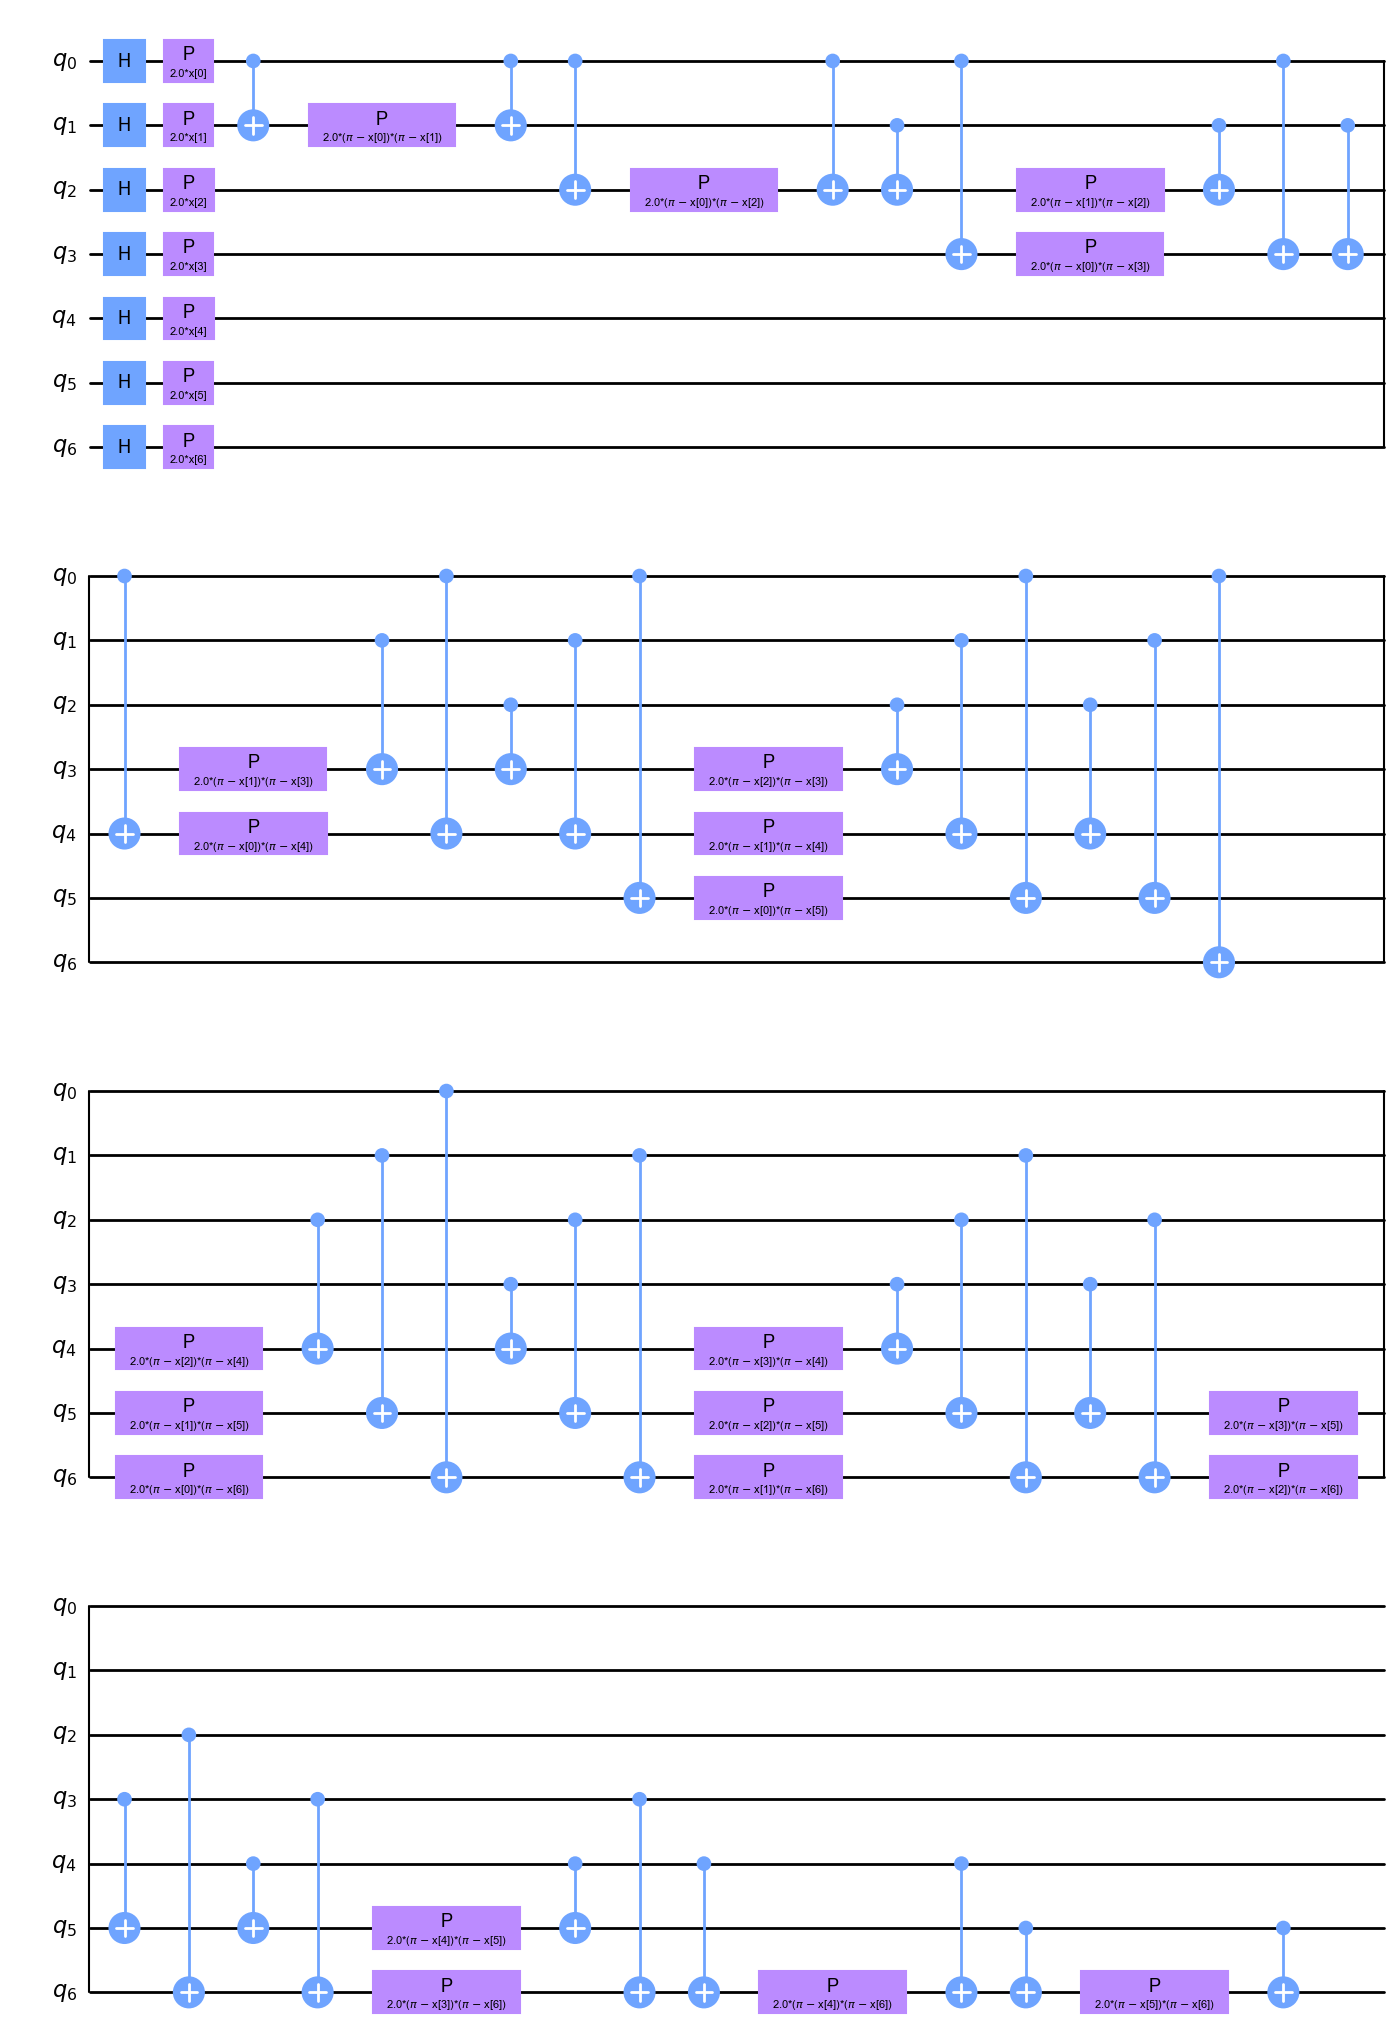

In [3]:
num_features = X_Train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

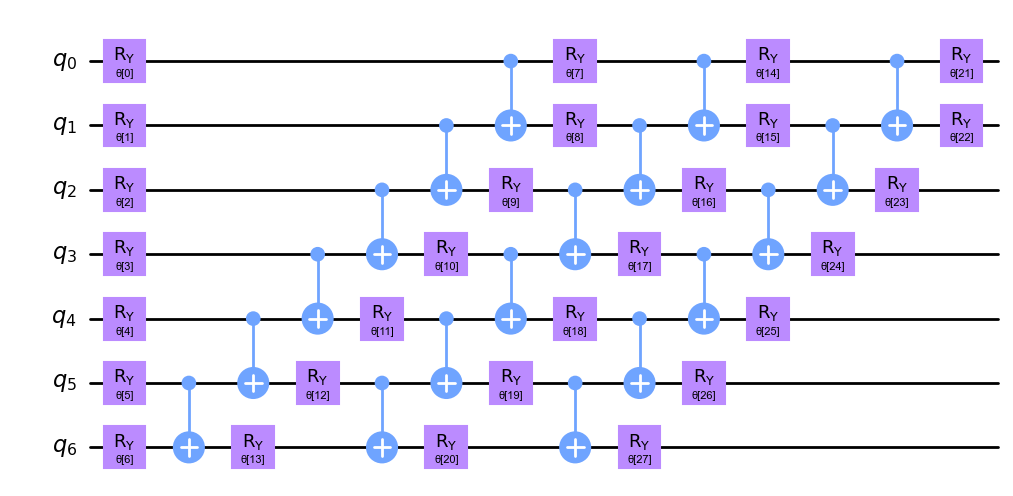

In [48]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [4]:
sampler = Sampler()
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
optimizer = COBYLA(maxiter=1000)
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_Train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

train_score_q4 = vqc.score(X_Train, y_train)
test_score_q4 = vqc.score(X_Test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

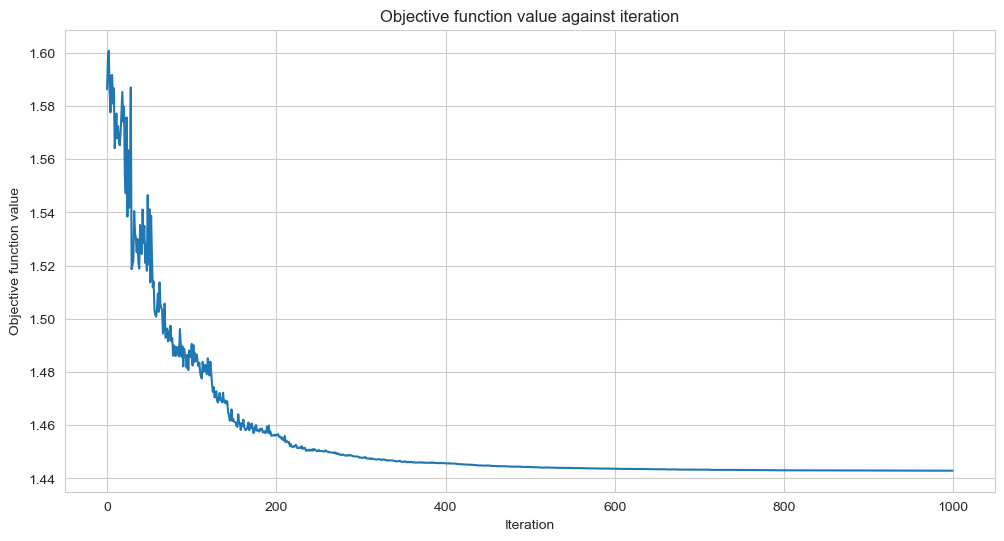

Quantum VQC on the training dataset: 0.63
Quantum VQC on the test dataset:     0.40


In [50]:
optimizer2 = SPSA(maxiter=1000)
vqc2 = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)
# clear objective value history
objective_func_vals = []

start = time.time()
vqc2.fit(X_Train, y_train)
elapsed = time.time() - start
train_score_q4_2 = vqc2.score(X_Train,y_train)
test_score_q4_2 = vqc2.score(X_Test,y_test)
print(f"Quantum VQC on the training dataset: {train_score_q4_2:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_2:.2f}")

In [5]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
fidelity = ComputeUncompute(sampler=sampler)
quantumKernel = FidelityQuantumKernel(fidelity=fidelity,feature_map=feature_map)
qsvc = QSVC(quantum_kernel=quantumKernel)
start = time.time()
qsvc.fit(X_Train, y_train)
elapsed = time.time() - start
train_score_q4_3 = qsvc.score(X_Train,y_train)
test_score_q4_3 = qsvc.score(X_Test,y_test)
print(f"Quantum VQC on the training dataset: {train_score_q4_3:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_3:.2f}")

Quantum VQC on the training dataset: 1.00
Quantum VQC on the test dataset:     0.40


In [ ]:
import math
from qiskit import QuantumCircuit

desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw()

